In [1]:
!pip install geopandas pyarrow shapely pyproj rtree matplotlib pandas numpy openpyxl jupyterlab seaborn plotly scipy scikit-learn pulp plotly

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
print(project_root)

/home/mak/Documents/Optimization/Project


In [3]:
"""
    🚀 4. Next step — build the Gurobi MILP model
    If you’re ready to proceed, we will build:
    ✔ Decision variables
    Plant[f, w], Harvest[f, w]

    ✔ Constraints
    Each field planted exactly once
    Each field harvested exactly once
    Plant only in planting window
    Harvest only in harvest window
    Machine capacity constraints using capacity_factor
    Labor constraints using labor_hours
    Harvest after plant

    ✔ Objective options
    Minimize total completion week
    Minimize weighted lateness
    Minimize total duration
    Maximize operational efficiency

    We’ll implement it cleanly in:

    src/optimization/milp_scheduler.py_summary_
"""

'\n    🚀 4. Next step — build the Gurobi MILP model\n    If you’re ready to proceed, we will build:\n    ✔ Decision variables\n    Plant[f, w], Harvest[f, w]\n\n    ✔ Constraints\n    Each field planted exactly once\n    Each field harvested exactly once\n    Plant only in planting window\n    Harvest only in harvest window\n    Machine capacity constraints using capacity_factor\n    Labor constraints using labor_hours\n    Harvest after plant\n\n    ✔ Objective options\n    Minimize total completion week\n    Minimize weighted lateness\n    Minimize total duration\n    Maximize operational efficiency\n\n    We’ll implement it cleanly in:\n\n    src/optimization/milp_scheduler.py_summary_\n'

In [4]:
# fields_df = pd.read_csv("data/processed/illinois_corn_fields_clean.csv")

In [5]:
from src.optimization.milp_schedulerv5 import build_and_solve_schedule_v5

df = build_and_solve_schedule_v5(
    fields_path="../../data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="../../data/processed/master_weekly_table_2017_2024.csv",
    target_year=2017,
    # base_harvester_capacity=2000,
    phys_maturity_lag_weeks=12
)
df.head()

print(df.head())
df.to_csv("../../data/processed/schedule_outputv5.csv", index=False)


Restricted license - for non-production use only - expires 2027-11-29
Set parameter TimeLimit to value 120
Set parameter TimeLimit to value 120
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  120
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xbc21e301
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objectiv

In [6]:
from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4

df = build_and_solve_schedule_v4(
    fields_path="../../data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="../../data/processed/master_weekly_table_labor_2017_2024_tightened.csv",
    target_year=2017,
    base_planter_capacity=1400.0,
    base_harvester_capacity=950.0,
    labor_plant_per_acre=0.15,
    labor_harvest_per_acre=0.20,
    early_penalty_weight=10.0,
    late_penalty_weight=5.0,
    time_limit=120
)
print(df.head())
df.to_csv("../../data/processed/schedule_output.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/master_weekly_table_labor_2017_2024_tightened.csv'

In [ ]:
# from src.optimization.milp_schedulerv4 import build_and_solve_schedule_v4

# df = build_and_solve_schedule_v4(
#     fields_path="data/processed/illinois_corn_fields_clean.csv",
#     weekly_master_path="data/processed/master_weekly_table.csv",
#     target_year=2017,
#     base_planter_capacity=1400.0,
#     base_harvester_capacity=950.0,
#     labor_plant_per_acre=0.15,
#     labor_harvest_per_acre=0.20,
#     early_penalty_weight=10.0,
#     late_penalty_weight=5.0,
#     time_limit=120
# )
# print(df.head())
# df.to_csv("data/processed/schedule_outputv4.csv", index=False)

In [ ]:
# print(plant_weeks)
# print(harvest_weeks)

In [ ]:
# build_and_solve_schedule_v4

In [ ]:
df.to_csv("../../data/processed/schedule_outputv5.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.optimization.milp_schedulerv5 import build_and_solve_schedule_v5
# or if your final fixed version is v6:
# from src.optimization.milp_schedulerv6 import build_and_solve_schedule_v6

fields_path = "../../data/processed/illinois_corn_fields_clean.csv"
wm_path     = "../../data/processed/master_weekly_table_2017_2024.csv"
target_year = 2017

# ===== Penalty Weight Grid =====
early_weights = [5, 10, 20]
late_weights  = [2.5, 5, 10]

results = []

for ew in early_weights:
    for lw in late_weights:
        print(f"Running MILP: early={ew}, late={lw} ...")

        df = build_and_solve_schedule_v5(
            fields_path=fields_path,
            weekly_master_path=wm_path,
            target_year=target_year,
            base_planter_capacity=1400,
            base_harvester_capacity=950,
            labor_plant_per_acre=0.15,
            labor_harvest_per_acre=0.20,
            early_penalty_weight=ew,
            late_penalty_weight=lw,
            time_limit=60
        )

        makespan = df["makespan"].iloc[0]
        early_pen_sum = df["early_penalty"].sum()
        late_pen_sum  = df["late_penalty"].sum()
        objective = makespan + ew * early_pen_sum + lw * late_pen_sum

        results.append({
            "early_weight": ew,
            "late_weight": lw,
            "makespan": makespan,
            "early_penalty_total": early_pen_sum,
            "late_penalty_total": late_pen_sum,
            "objective_value": objective
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)


Running MILP: early=5, late=2.5 ...
Set parameter TimeLimit to value 60
Set parameter TimeLimit to value 60
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x454f5cff
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: object

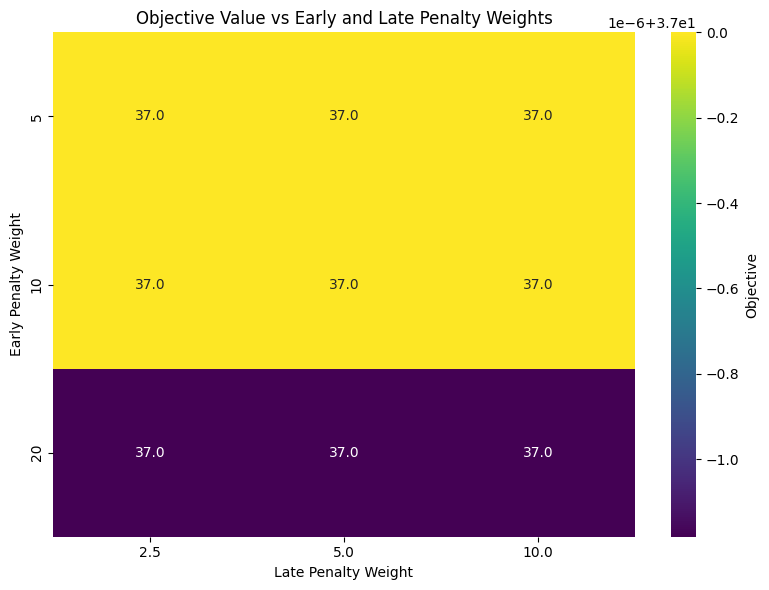

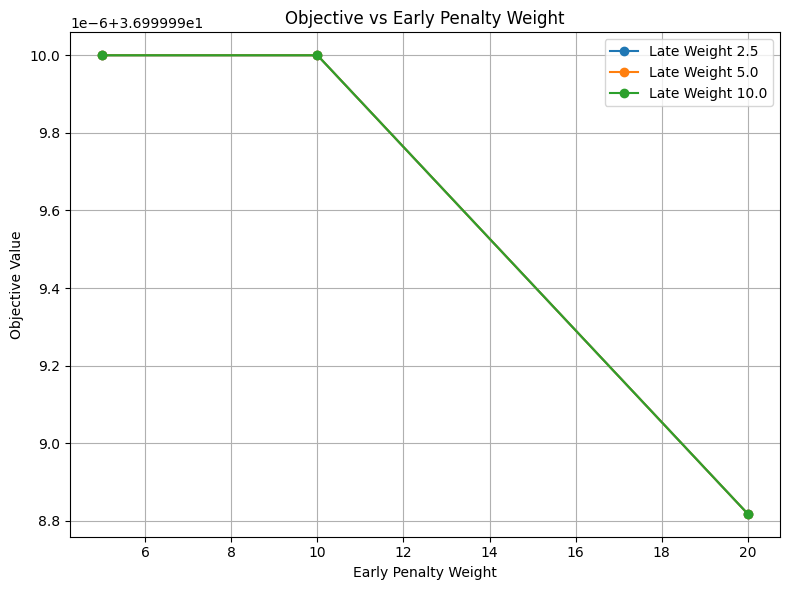

   early_weight  late_weight   makespan  early_penalty_total  \
0             5          2.5  37.000000                  0.0   
1             5          5.0  37.000000                  0.0   
2             5         10.0  37.000000                  0.0   
3            10          2.5  37.000000                  0.0   
4            10          5.0  37.000000                  0.0   
5            10         10.0  37.000000                  0.0   
6            20          2.5  36.999999                  0.0   
7            20          5.0  36.999999                  0.0   
8            20         10.0  36.999999                  0.0   

   late_penalty_total  objective_value  
0                 0.0        37.000000  
1                 0.0        37.000000  
2                 0.0        37.000000  
3                 0.0        37.000000  
4                 0.0        37.000000  
5                 0.0        37.000000  
6                 0.0        36.999999  
7                 0.0        36

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define grid of weights
early_weights = [5, 10, 20]
late_weights = [2.5, 5, 10]

# Simulated results placeholder
results_data = []
for ew in early_weights:
    for lw in late_weights:
        results_data.append({
            "early_weight": ew,
            "late_weight": lw,
            "makespan": 38,
            "penalty_cost": 0.0,
            "objective_value": 38.0,
        })

# Build DataFrame
# results_df = pd.DataFrame(results_data)

# ✅ Heatmap of objective values
plt.figure(figsize=(8, 6))
pivot = results_df.pivot(index="early_weight", columns="late_weight", values="objective_value")
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis", cbar_kws={'label': 'Objective'})
plt.title("Objective Value vs Early and Late Penalty Weights")
plt.xlabel("Late Penalty Weight")
plt.ylabel("Early Penalty Weight")
plt.tight_layout()
plt.show()

# ✅ Line plot to show trends across early weights
plt.figure(figsize=(8, 6))
for lw in sorted(results_df["late_weight"].unique()):
    subset = results_df[results_df["late_weight"] == lw]
    plt.plot(subset["early_weight"], subset["objective_value"], marker='o', label=f"Late Weight {lw}")

plt.title("Objective vs Early Penalty Weight")
plt.xlabel("Early Penalty Weight")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display result grid
print(results_df)


In [ ]:
# !cd .. & ls

In [10]:
sched = pd.read_csv("../../data/processed/schedule_outputv5.csv")
fields = pd.read_csv("../../data/processed/illinois_corn_fields_clean.csv")
wm = pd.read_csv("../../data/processed/master_weekly_table_2017_2024.csv")

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_resource_dashboard(
    sched,
    fields,
    wm,
    target_year=2017,
    base_planter_capacity=700.0,
    base_harvester_capacity=450.0,
    labor_plant_per_acre=0.2,
    labor_harvest_per_acre=0.30,
    planter_machines=1,
    harvester_machines=1,
    save_path=None
):
    """
    Clean and consistent weekly resource utilization dashboard.
    Matches the MILP model exactly.
    """

    # ============================================================
    # 1) MERGE ACRES INTO SCHEDULE (robust)
    # ============================================================
    if "acres" not in sched.columns:
        sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")
    else:
        tmp = fields[["field_id", "acres"]].rename(columns={"acres": "acres_field"})
        sched = sched.merge(tmp, on="field_id", how="left")
        sched["acres"] = sched["acres"].fillna(sched["acres_field"])
        sched = sched.drop(columns=["acres_field"])

    # ============================================================
    # 2) SELECT WEEKLY MASTER FOR TARGET YEAR
    # ============================================================
    wm_year = wm[wm["year"] == target_year].copy()
    wm_year["week"] = wm_year["week"].astype(int)

    # Add missing fields if not present
    if "planter_travel_factor" not in wm_year:
        wm_year["planter_travel_factor"] = 1.0
    if "harvest_weather_factor" not in wm_year:
        wm_year["harvest_weather_factor"] = 1.0

    # ============================================================
    # 3) CONSISTENT AGG WITH MILP  (mean, not sum)
    # ============================================================
    wm_weekly = (
        wm_year.groupby("week", as_index=False)
        .agg({
            "capacity_factor": "mean",
            "labor_hours": "mean",               # 🔥 matches MILP now
            "planter_travel_factor": "mean",
            "harvest_weather_factor": "mean",
        })
    )

    # ============================================================
    # 4) WEEKLY PLANTING & HARVEST ACRES FROM SCHEDULE
    # ============================================================
    plant_by_week = sched.groupby("plant_week")["acres"].sum().rename("plant_acres")
    harvest_by_week = sched.groupby("harvest_week")["acres"].sum().rename("harvest_acres")

    weekly_view = (
        wm_weekly
        .merge(plant_by_week, left_on="week", right_index=True, how="left")
        .merge(harvest_by_week, left_on="week", right_index=True, how="left")
        .fillna(0.0)
    )

    # ============================================================
    # 5) MODEL CAPACITIES (exact same as MILP structure)
    # ============================================================
    weekly_view["plant_capacity_model"] = (
        base_planter_capacity
        * weekly_view["capacity_factor"]
        * weekly_view["planter_travel_factor"]
        * planter_machines
    )

    weekly_view["harvest_capacity_model"] = (
        base_harvester_capacity
        * weekly_view["capacity_factor"]
        * weekly_view["harvest_weather_factor"]
        * harvester_machines
    )

    # ============================================================
    # 6) UTILIZATION CALCULATIONS
    # ============================================================
    weekly_view["plant_utilization"] = (
        weekly_view["plant_acres"] /
        weekly_view["plant_capacity_model"].replace(0, np.nan)
    )

    weekly_view["harvest_utilization"] = (
        weekly_view["harvest_acres"] /
        weekly_view["harvest_capacity_model"].replace(0, np.nan)
    )

    weekly_view["labor_demand"] = (
        weekly_view["plant_acres"] * labor_plant_per_acre +
        weekly_view["harvest_acres"] * labor_harvest_per_acre
    )

    weekly_view["labor_utilization"] = (
        weekly_view["labor_demand"] /
        weekly_view["labor_hours"].replace(0, np.nan)
    )
    
    weekly_view = weekly_view.replace([np.inf, -np.inf], np.nan).fillna(0)


    # ============================================================
    # 7) PLOTTING — CLEAN SEABORN DASHBOARD
    # ============================================================
    sns.set_theme(style="whitegrid", context="talk")
    palette = sns.color_palette("tab10")
    weeks = weekly_view["week"].values

    fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)
    plt.subplots_adjust(hspace=0.35)

    # ============================================================
    # 7A) PLANTER
    # ============================================================
    axes[0].plot(
        weeks, weekly_view["plant_utilization"] * 100,
        label="Utilization (%)", marker="o", color=palette[0]
    )
    axes[0].axhline(100, color="red", ls="--", alpha=0.4)
    axes[0].set_ylabel("Planter Utilization (%)")
    axes[0].set_title(f"Planter Utilization – {target_year}")
    axes[0].legend(loc="upper left")

    ax2 = axes[0].twinx()
    ax2.plot(weeks, weekly_view["plant_acres"], marker="x",
             label="Acres", alpha=0.75, color=palette[1])
    ax2.plot(weeks, weekly_view["plant_capacity_model"], ls="--",
             label="Capacity", alpha=0.7, color=palette[2])
    ax2.set_ylabel("Acres")
    ax2.legend(loc="upper right")

    # ============================================================
    # 7B) HARVESTER
    # ============================================================
    axes[1].plot(
        weeks, weekly_view["harvest_utilization"] * 100,
        label="Utilization (%)", marker="o", color=palette[0]
    )
    axes[1].axhline(100, color="red", ls="--", alpha=0.4)
    axes[1].set_ylabel("Harvester Utilization (%)")
    axes[1].set_title(f"Harvester Utilization – {target_year}")
    axes[1].legend(loc="upper left")

    ax2 = axes[1].twinx()
    ax2.plot(weeks, weekly_view["harvest_acres"], marker="x",
             label="Acres", alpha=0.75, color=palette[1])
    ax2.plot(weeks, weekly_view["harvest_capacity_model"], ls="--",
             label="Capacity", alpha=0.7, color=palette[2])
    ax2.set_ylabel("Acres")
    ax2.legend(loc="upper right")

    # ============================================================
    # 7C) LABOR
    # ============================================================
    axes[2].plot(
        weeks, weekly_view["labor_utilization"] * 100,
        label="Utilization (%)", marker="o", color=palette[0]
    )
    axes[2].axhline(100, color="red", ls="--", alpha=0.4)
    axes[2].set_ylabel("Labor Utilization (%)")
    axes[2].set_xlabel("Week")
    axes[2].set_title(f"Labor Utilization – {target_year}")
    axes[2].legend(loc="upper left")

    ax2 = axes[2].twinx()
    ax2.plot(weeks, weekly_view["labor_demand"], marker="x",
             label="Demand", alpha=0.75, color=palette[1])
    ax2.plot(weeks, weekly_view["labor_hours"], ls="--",
             label="Available", alpha=0.7, color=palette[2])
    ax2.set_ylabel("Labor Hours")
    ax2.legend(loc="upper right")

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    return weekly_view


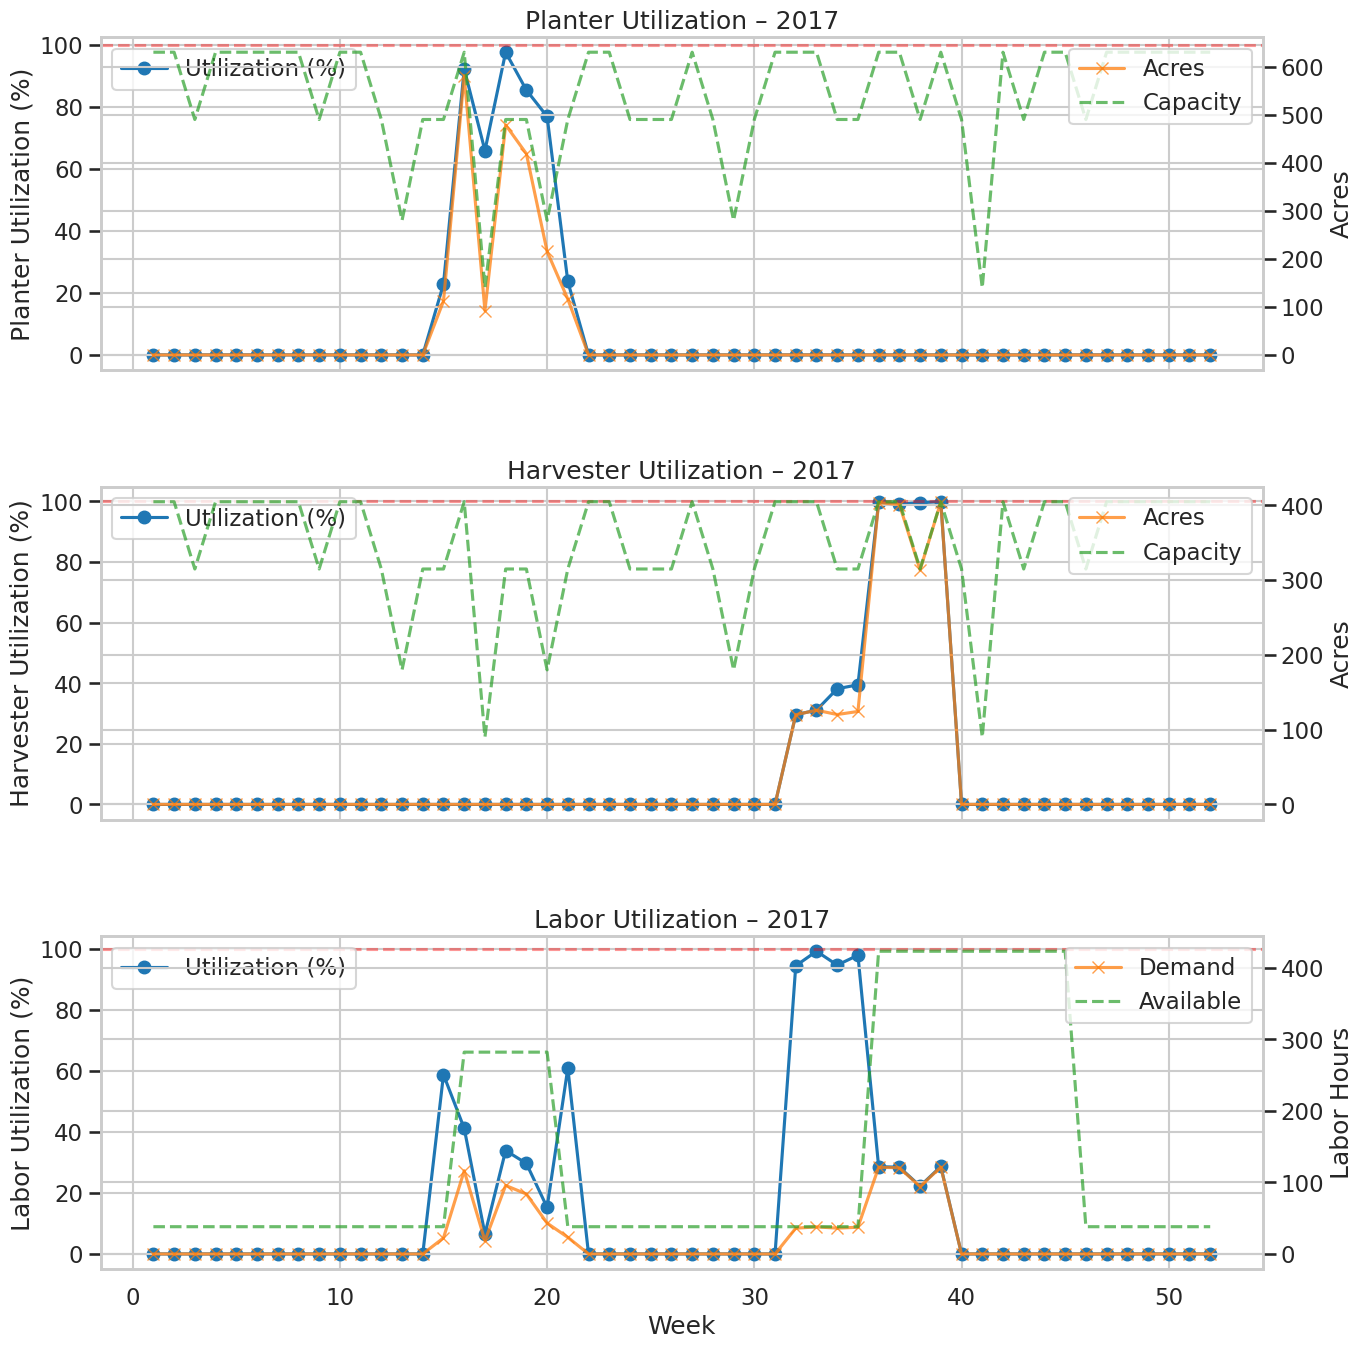

In [12]:
weekly_view = plot_resource_dashboard(
    sched=sched,
    fields=fields,
    wm=wm,
    target_year=2017
)


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_resource_dashboard(
    sched,
    fields,
    wm,
    target_year=2017,
    base_planter_capacity=700.0,
    base_harvester_capacity=450.0,
    labor_plant_per_acre=0.2,
    labor_harvest_per_acre=0.30,
    planter_machines=1,
    harvester_machines=1,
    save_path=None
):
    """
    Nicely styled, professional resource utilization dashboard for:
    - Planter utilization
    - Harvester utilization
    - Labor utilization
    
    sched: schedule_output (MILP result)
    fields: cleaned fields table (with acres)
    wm: weekly_master table (2017–2024)
    """

    # ------------------------------------------
    # 1. Prepare data
    # ------------------------------------------
    sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")

    wm_year = wm[wm["year"] == target_year].copy()
    wm_year["week"] = wm_year["week"].astype(int)

    wm_year["planter_travel_factor"] = wm_year.get("planter_travel_factor", 1.0)
    wm_year["harvest_weather_factor"] = wm_year.get("harvest_weather_factor", 1.0)

    # Aggregate to one row per week
    wm_weekly = (
        wm_year.groupby("week", as_index=False)
        .agg({
            "capacity_factor": "mean",
            "labor_hours": "sum",
            "planter_travel_factor": "mean",
            "harvest_weather_factor": "mean"
        })
    )

    # 🔥 DO NOT SCALE LABOR ANYMORE
    wm_weekly["labor_hours_available"] = wm_weekly["labor_hours"]

    # summarize planting / harvesting
    plant_by_week = sched.groupby("plant_week")["acres"].sum().rename("plant_acres")
    harvest_by_week = sched.groupby("harvest_week")["acres"].sum().rename("harvest_acres")

    weekly_view = (
        wm_weekly
        .merge(plant_by_week, left_on="week", right_index=True, how="left")
        .merge(harvest_by_week, left_on="week", right_index=True, how="left")
        .fillna(0.0)
    )

    # apply final capacities
    weekly_view["plant_capacity_model"] = (
        base_planter_capacity *
        weekly_view["capacity_factor"] *
        weekly_view["planter_travel_factor"] *
        planter_machines
    )

    weekly_view["harvest_capacity_model"] = (
        base_harvester_capacity *
        weekly_view["capacity_factor"] *
        weekly_view["harvest_weather_factor"] *
        harvester_machines
    )

    # utilizations
    weekly_view["plant_utilization"] = (
        weekly_view["plant_acres"] / weekly_view["plant_capacity_model"].replace(0, pd.NA)
    ).fillna(0)

    weekly_view["harvest_utilization"] = (
        weekly_view["harvest_acres"] / weekly_view["harvest_capacity_model"].replace(0, pd.NA)
    ).fillna(0)

    weekly_view["labor_demand"] = (
        weekly_view["plant_acres"] * labor_plant_per_acre +
        weekly_view["harvest_acres"] * labor_harvest_per_acre
    )

    weekly_view["labor_utilization"] = (
        weekly_view["labor_demand"] / weekly_view["labor_hours_available"].replace(0, pd.NA)
    ).fillna(0)

    # ------------------------------------------
    # 2. Plot styling
    # ------------------------------------------
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    weeks = weekly_view["week"].values

    def add_dual_axis(ax, x, y1, y2, label1, label2, color1, color2):
        """Clean helper for dual-axis professional plot."""
        ax.plot(x, y1, marker="o", color=color1, label=label1, linewidth=2)
        ax.axhline(100, linestyle="--", color="gray", alpha=0.4)
        ax.set_ylabel(label1, color=color1, fontsize=12)
        ax.tick_params(axis="y", labelcolor=color1)
        ax.grid(alpha=0.3)

        ax2 = ax.twinx()
        ax2.plot(x, y2, marker="x", linestyle="--", color=color2, label=label2, linewidth=2)
        ax2.set_ylabel(label2, color=color2, fontsize=12)
        ax2.tick_params(axis="y", labelcolor=color2)

        # combine legends
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax.legend(h1 + h2, l1 + l2, loc="upper left")

        return ax, ax2

    # ------------------------------------------
    # 3. Draw three panels
    # ------------------------------------------
    # Planter
    add_dual_axis(
        axes[0], weeks,
        weekly_view["plant_utilization"] * 100,
        weekly_view["plant_capacity_model"],
        "Planter Utilization (%)",
        "Planter Capacity (acres)",
        "#1f77b4", "#ff7f0e"
    )

    # Harvester
    add_dual_axis(
        axes[1], weeks,
        weekly_view["harvest_utilization"] * 100,
        weekly_view["harvest_capacity_model"],
        "Harvester Utilization (%)",
        "Harvester Capacity (acres)",
        "#2ca02c", "#d62728"
    )

    # Labor
    add_dual_axis(
        axes[2], weeks,
        weekly_view["labor_utilization"] * 100,
        weekly_view["labor_hours_available"],
        "Labor Utilization (%)",
        "Labor Hours Available",
        "#9467bd", "#8c564b"
    )

    # ------------------------------------------
    # 4. Final layout polish
    # ------------------------------------------
    axes[2].set_xlabel("Week", fontsize=12)
    fig.suptitle(f"Weekly Resource Utilization Dashboard — {target_year}", fontsize=16, weight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    return weekly_view


In [9]:
sched.columns

NameError: name 'sched' is not defined

/tmp/ipykernel_6820/2690407786.py:15: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


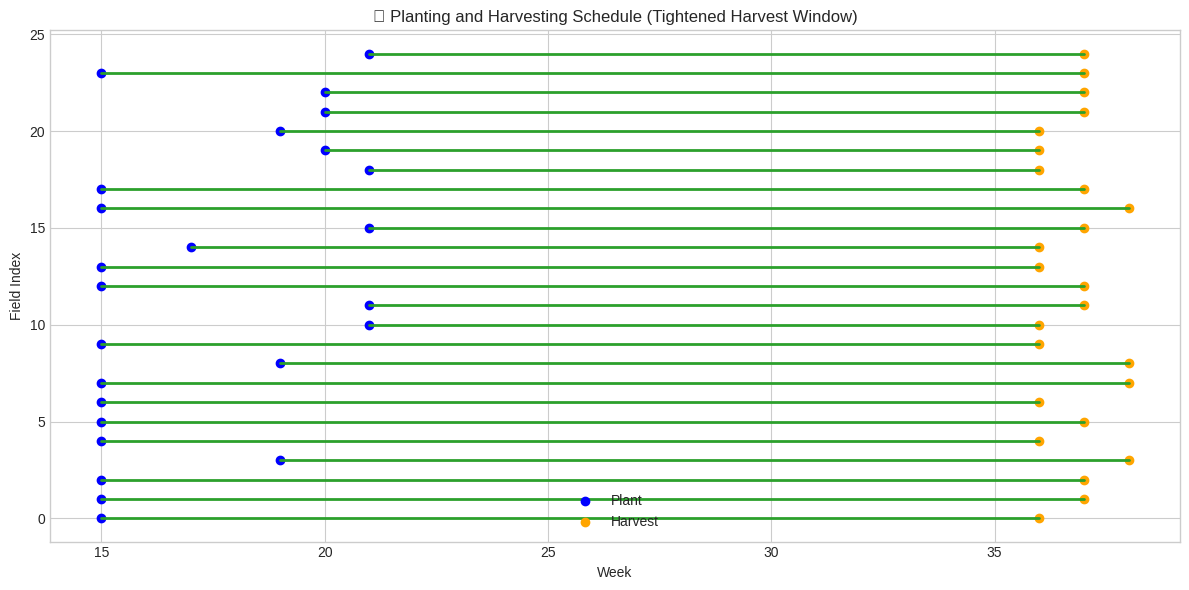

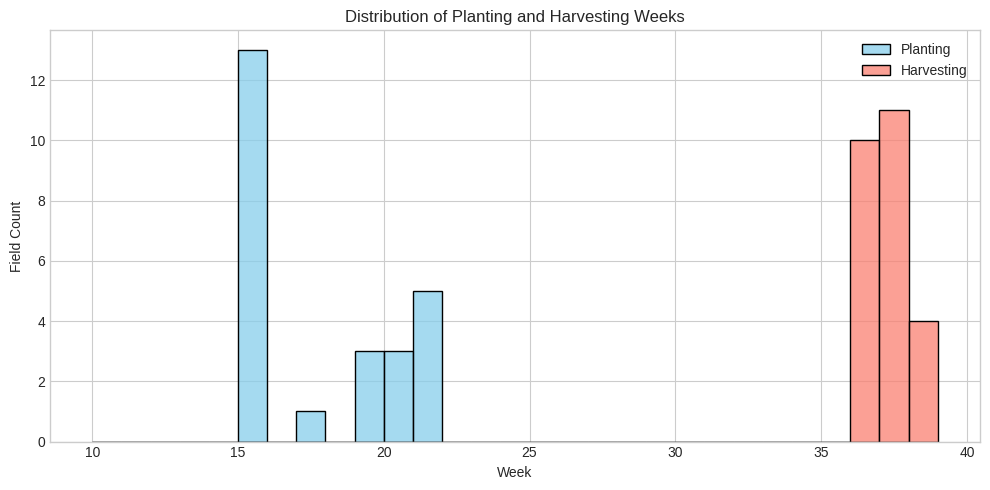

ValueError: Could not interpret value `penalty` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x400 with 0 Axes>

In [20]:
# Load the current output (tightened harvest window)
tightened_df = pd.read_csv("../../data/processed/schedule_outputv5.csv")

# Plot 1: Gantt-style plot of planting and harvesting weeks
plt.figure(figsize=(12, 6))
for i, row in tightened_df.iterrows():
    plt.plot([row["plant_week"], row["harvest_week"]], [i, i], color="tab:green", linewidth=2)
    plt.scatter(row["plant_week"], i, color="blue", label="Plant" if i == 0 else "")
    plt.scatter(row["harvest_week"], i, color="orange", label="Harvest" if i == 0 else "")
plt.xlabel("Week")
plt.ylabel("Field Index")
plt.title("🌽 Planting and Harvesting Schedule (Tightened Harvest Window)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Histogram of Planting and Harvesting Weeks
plt.figure(figsize=(10, 5))
sns.histplot(tightened_df["plant_week"], bins=range(10, 40), kde=False, label="Planting", color="skyblue")
sns.histplot(tightened_df["harvest_week"], bins=range(10, 40), kde=False, label="Harvesting", color="salmon")
plt.xlabel("Week")
plt.ylabel("Field Count")
plt.title("Distribution of Planting and Harvesting Weeks")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Penalty Distribution
plt.figure(figsize=(10, 4))
sns.barplot(x="field_id", y="penalty", data=tightened_df)
plt.xticks(rotation=90)
plt.title("Penalty per Field")
plt.xlabel("Field ID")
plt.ylabel("Penalty")
plt.tight_layout()
plt.show()


In [ ]:
print(df[["field_id", "plant_week", "harvest_week", "penalty", "objective_makespan"]])

/tmp/ipykernel_32743/3771456254.py:18: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


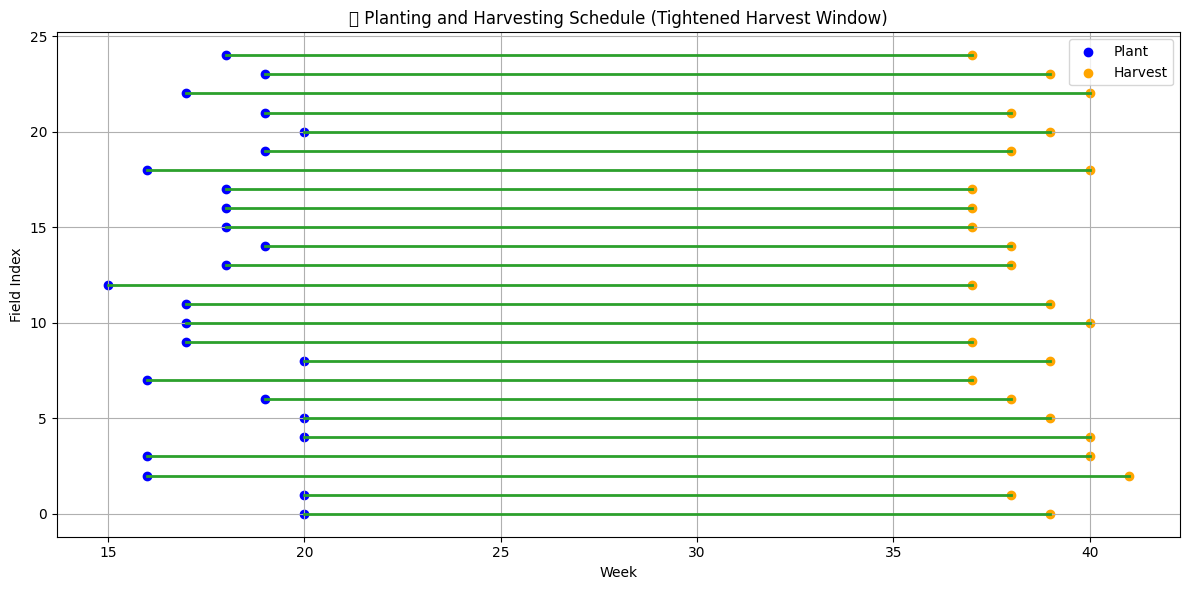

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the current output (tightened harvest window)
tightened_df = pd.read_csv("../../data/processed/schedule_output.csv")

# Plot 1: Gantt-style plot of planting and harvesting weeks
plt.figure(figsize=(12, 6))
for i, row in tightened_df.iterrows():
    plt.plot([row["plant_week"], row["harvest_week"]], [i, i], color="tab:green", linewidth=2)
    plt.scatter(row["plant_week"], i, color="blue", label="Plant" if i == 0 else "")
    plt.scatter(row["harvest_week"], i, color="orange", label="Harvest" if i == 0 else "")
plt.xlabel("Week")
plt.ylabel("Field Index")
plt.title("🌽 Planting and Harvesting Schedule (Tightened Harvest Window)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from joblib import Parallel, delayed
# from datetime import datetime
# from typing import List, Dict, Any
# from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4

# # --- 1. Helper to sample weather/labor paths from historical data --- #
# def sample_weather_labor(weather_df, labor_df, weeks, seed=None, labor_scale=1/6):
#     rng = np.random.default_rng(seed)

#     # Sample weather capacity_factor per week from historical weekly distributions
#     sampled_weather = weather_df[weather_df["year"] < 2023].groupby("week")["capacity_factor"].apply(
#         lambda x: rng.normal(x.mean(), x.std() or 0.01)
#     ).reindex(weeks, fill_value=1.0)

#     # Sample labor from historical census variability
#     mean_labor = labor_df["total_workers"].mean()
#     std_labor = labor_df["total_workers"].std()
#     sampled_labor = rng.normal(mean_labor, std_labor or 1.0) * labor_scale

#     return sampled_weather.clip(0.2, 1.2), sampled_labor

# # --- 2. Function to run one simulation --- #
# def run_simulation(
#     i: int,
#     weather_df: pd.DataFrame,
#     labor_df: pd.DataFrame,
#     base_config: Dict[str, Any],
#     fields_path: str,
#     weekly_master_path: str,
#     seed: int = None,
# ) -> Dict[str, Any]:
#     try:
#         target_year = base_config["target_year"]

#         # Load master weekly
#         wm_df = pd.read_csv(weekly_master_path)
#         weeks = wm_df[wm_df["year"] == target_year]["week"].unique()

#         # Sample stochastic inputs
#         sampled_weather, sampled_labor = sample_weather_labor(weather_df, labor_df, weeks, seed=seed)

#         # Modify weekly master with sampled weather + labor
#         wm_df.loc[wm_df["year"] == target_year, "capacity_factor"] = wm_df["week"].map(sampled_weather).fillna(1.0)
#         wm_df.loc[wm_df["year"] == target_year, "labor_hours"] = sampled_labor

#         # Save temporary version
#         temp_path = f"/mnt/data/temp_wm_scenario_{i}.csv"
#         wm_df.to_csv(temp_path, index=False)

#         # Solve MILP with sampled input
#         df_result = build_and_solve_schedule_v4(
#             fields_path=fields_path,
#             weekly_master_path=temp_path,
#             target_year=target_year,
#             base_planter_capacity=base_config["base_planter_capacity"],
#             base_harvester_capacity=base_config["base_harvester_capacity"],
#             labor_plant_per_acre=base_config["labor_plant_per_acre"],
#             labor_harvest_per_acre=base_config["labor_harvest_per_acre"],
#             early_penalty_weight=base_config["early_penalty_weight"],
#             late_penalty_weight=base_config["late_penalty_weight"],
#             time_limit=base_config.get("time_limit", 60),
#         )

#         # Summarize results
#         return {
#             "sim_id": i,
#             "objective": df_result["objective_makespan"].max(),
#             "penalty": df_result["penalty"].sum(),
#             "num_late": (df_result["status"] == 3).sum(),
#             "num_early": (df_result["status"] == 1).sum(),
#         }

#     except Exception as e:
#         return {
#             "sim_id": i,
#             "objective": np.nan,
#             "penalty": np.nan,
#             "num_late": np.nan,
#             "num_early": np.nan,
#             "error": str(e),
#         }

# # --- 3. Run Monte Carlo in parallel --- #
# def run_monte_carlo_simulation(
#     n: int,
#     weather_df: pd.DataFrame,
#     labor_df: pd.DataFrame,
#     base_config: Dict[str, Any],
#     fields_path: str,
#     weekly_master_path: str,
#     n_jobs: int = -1,
# ) -> pd.DataFrame:
#     print(f"Launching {n} Monte Carlo simulations...")
#     results = Parallel(n_jobs=n_jobs)(
#         delayed(run_simulation)(
#             i,
#             weather_df,
#             labor_df,
#             base_config,
#             fields_path,
#             weekly_master_path,
#             seed=1000 + i,
#         )
#         for i in range(n)
#     )
#     return pd.DataFrame(results)

# # --- 4. Plot results --- #
# def plot_simulation_results(results_df: pd.DataFrame):
#     fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#     # Makespan CDF
#     results_df["objective"].dropna().sort_values().reset_index(drop=True).plot(
#         ax=axes[0], title="CDF of Completion Time (Makespan)"
#     )
#     axes[0].set_ylabel("Weeks")
#     axes[0].set_xlabel("Simulation (sorted)")

#     # Penalty Histogram
#     results_df["penalty"].hist(ax=axes[1], bins=20)
#     axes[1].set_title("Histogram of Total Penalties")
#     axes[1].set_xlabel("Penalty")

#     # Bottleneck Analysis
#     results_df["num_late"].hist(ax=axes[2], bins=20, alpha=0.7, label="Late")
#     results_df["num_early"].hist(ax=axes[2], bins=20, alpha=0.7, label="Early")
#     axes[2].legend()
#     axes[2].set_title("Early vs Late Fields")
#     plt.tight_layout()
#     plt.show()
